In [1]:
import numpy as np 

import torch
import torch.nn as nn
import torch.nn.functional as F 

from torch.optim import Adam

from torchtext import datasets
from torchtext.data import Field
from torchtext.data import BucketIterator

from tqdm import tqdm
import matplotlib.pyplot as plt 
from time import time

from torchtext.data.metrics import bleu_score


In [3]:
import torchtext 
import numpy
import matplotlib
matplotlib.__version__
# torchtext.__version__
# numpy.__version__

'3.3.2'

In [5]:
with open("./requirements.txt") as f:
    for string_ in f:
        print(string_)

torch==1.7.1 sa

torchtext==0.8.1

numpy==1.19.2

tqdm==4.51.0

matplotlib==3.3.2



In [3]:
def time_check(start):
    total_time = round(time() - start)
    min, seconds = divmod(total_time, 60)
    return "{:02}:{:02}".format(int(min),int(seconds))
time_check(now)

'00:00'

In [4]:
class Args(dict): 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

In [5]:
config = Args({
    "d_k": 64,
    "n_head": 8,
    "dropout": 0.1,
    "d_ff": 2048,
    "n_enc_layer": 6,
    "n_dec_layer": 6,
    "src_vocab_size": 1000,
    "dec_vocab_size": 1000,
    "pad_idx": 0,
    "device": torch.device("cpu")
})
config.d_model= config.d_k * config.n_head

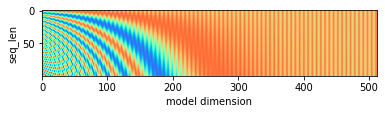

<Figure size 432x288 with 0 Axes>

In [6]:
def positionalEncoding(seq_len, d_model):
    pe = torch.zeros(seq_len, d_model)
    
    for i in range(d_model//2):
        pe[:,2*i] = torch.sin(torch.Tensor(range(seq_len))/(10**(8*i/d_model)))
        pe[:,2*i+1] = torch.cos(torch.Tensor(range(seq_len))/(10**(8*i/d_model)))
    return pe
output = np.array(positionalEncoding(100, 512))
plt.imshow(output,cmap=plt.cm.rainbow)
plt.xlabel("model dimension")
plt.ylabel("seq_len")
plt.show()
plt.savefig("Figure/pos_enc.png")

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super(MultiHeadAttention, self).__init__()
        self.config = config

        self.W_Q = nn.Linear(self.config.d_model, self.config.d_model)
        self.W_K = nn.Linear(self.config.d_model, self.config.d_model)
        self.W_V = nn.Linear(self.config.d_model, self.config.d_model)
        self.W_O = nn.Linear(self.config.d_model, self.config.d_model)
        self.dropout = nn.Dropout(self.config.dropout)
    
    def forward(self, query, keyvalue, mask):
        #query: bxp1xd_model, keyvalue: bxp2xd_model: torch.FloatTensor 
        #mask: bxp1xp2 : torch.BoolTensor
        b, p1, _ = query.size()
        b, p2, _ = keyvalue.size()

        q = self.W_Q(query).view(b, p1, self.config.n_head, self.config.d_k).transpose(1,2) # bxhxp1xd_k
        k = self.W_K(keyvalue).view(b, p2, self.config.n_head, self.config.d_k).transpose(1,2) # bxhxp2xd_k
        v = self.W_V(keyvalue).view(b, p2, self.config.n_head, self.config.d_k).transpose(1,2) # bxhxp2xd_k

        mask = mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1) # bxhxp1xp2

        attention = torch.matmul(q, k.transpose(-1,-2)).mul_(self.config.d_k ** (-0.5) )
        attention.masked_fill_(mask, -1e9)
        attention = F.softmax(attention, dim = -1) # bxhxp1xp2
        assert attention.shape == (b, self.config.n_head, p1, p2)
        attention_dropped = self.dropout(attention)

        output = torch.matmul(attention_dropped, v) #bxhxp1xd_k
        output = output.transpose(1,2).reshape(b, p1, -1)  #bxp1xd_model
        output = self.W_O(output) # bxp1xd_model
        
        return output, attention

In [8]:
model = MultiHeadAttention(config)
b, p1, p2 = 3, 4, 5
query, keyvalue = torch.randn(b, p1, config.d_model), torch.randn(b, p2, config.d_model)
random_mask = torch.randint(2, (b, p1, p2)) == 1
pad_mask = torch.sort(random_mask)[0]

print("random_mask\n", random_mask[0])
self_attn_mask = torch.tril(torch.ones(p1,p1)).unsqueeze(0).repeat(b, 1, 1) == 0
print("pad_mask\n", pad_mask[0])
print("mask_addition\n",torch.logical_or(random_mask, pad_mask)[0])
#1.
output, attention = model(query, keyvalue, random_mask)
print("attention for random_mask\n",  attention[0,0].detach().numpy())
#2
output, attention = model(query, query, self_attn_mask)
print("attention for self_attention\n", attention[0,0].detach().numpy())
#3
output, attention = model(query, keyvalue, pad_mask)
print("attention for pad_mask\n",  attention[0,0].detach().numpy())
#4
output, attention = model(query, keyvalue, torch.logical_or(random_mask, pad_mask))
print("attention and combined_mask\n",  attention[0,0].detach().numpy())

random_mask
 tensor([[False,  True,  True,  True, False],
        [False, False,  True,  True, False],
        [ True,  True,  True, False,  True],
        [ True,  True,  True,  True, False]])
pad_mask
 tensor([[False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False,  True,  True,  True,  True],
        [False,  True,  True,  True,  True]])
mask_addition
 tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]])
attention for random_mask
 [[0.5075223  0.         0.         0.         0.49247772]
 [0.25797775 0.20769455 0.         0.         0.5343277 ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]]
attention for self_attention
 [[1.         0.         0.         0.        ]
 [0.4878009  0.51219916 0.         0.        ]
 [0.41560122 0.34094614 0.24345265 

In [9]:
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
  
        self.multihead_attn = MultiHeadAttention(config)      
        self.feed_forward = nn.Sequential(
            nn.Linear(self.config.d_model, self.config.d_ff),
            nn.ReLU(),
            nn.Dropout(self.config.dropout),
            nn.Linear(self.config.d_ff, self.config.d_model))
        
        self.attn_norm = nn.LayerNorm(self.config.d_model)
        self.ffn_norm = nn.LayerNorm(self.config.d_model)
        self.attn_dropout = nn.Dropout(self.config.dropout)
        self.ffn_dropout = nn.Dropout(self.config.dropout)
    def forward(self, src, mask):
        # src: bxpxd_model FloatTensor
        # mask: bxpxp BoolTensor
        b, p, check_dim = src.size()
        assert check_dim == self.config.d_model
        assert mask.size() == (b, p, p)

        output, attention = self.multihead_attn(src, src, mask)
        output = self.attn_norm(src + self.attn_dropout(output))

        output_ = self.feed_forward(output)
        output = self.ffn_norm(output + self.ffn_dropout(output_))

        return output, attention

In [10]:
model = EncoderLayer(config)
b, p1, p2 = 3, 4, 5
test = torch.randn(b, p1, config.d_model)
random_mask = torch.randint(2, (b, p1, p1)) == 1
#1.
output, attention = model(test, random_mask)
assert test.shape == output.shape

In [11]:
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
  
        self.self_attn = MultiHeadAttention(config)     
        self.cross_attn = MultiHeadAttention(config)
        self.feed_forward = nn.Sequential(
            nn.Linear(self.config.d_model, self.config.d_ff),
            nn.ReLU(),
            nn.Dropout(self.config.dropout),
            nn.Linear(self.config.d_ff, self.config.d_model))
        
        self.self_attn_norm = nn.LayerNorm(self.config.d_model)
        self.cross_attn_norm = nn.LayerNorm(self.config.d_model)
        self.ffn_norm = nn.LayerNorm(self.config.d_model)
        self.self_attn_dropout = nn.Dropout(self.config.dropout)
        self.cross_attn_dropout = nn.Dropout(self.config.dropout)
        self.ffn_dropout = nn.Dropout(self.config.dropout)
    def forward(self, src, target, self_mask, cross_mask):
        # src: bxp1xd_model FloatTensor
        # target: bxp2xd_model FloatTensor
        # self_mask: bxp2xp2 BoolTensor
        # cross_mask: bxp2xp1 BoolTensor
        b, p1, check_dim = src.size()
        p2 = target.size()[1]
        assert check_dim == self.config.d_model
        assert target.size() == (b, p2, self.config.d_model)
        assert self_mask.size() == (b, p2, p2)
        assert cross_mask.size() == (b, p2, p1)

        output, self_attention = self.self_attn(target, target, self_mask)
        output = self.self_attn_norm(target + self.self_attn_dropout(output))

        output_, cross_attention = self.cross_attn(output, src, cross_mask)
        output = self.cross_attn_norm(output + self.cross_attn_dropout(output_))

        output_ = self.feed_forward(output)
        output = self.ffn_norm(output + self.ffn_dropout(output_))

        return output, self_attention, cross_attention

In [12]:
model = DecoderLayer(config)
b, p1, p2 = 3, 4, 5
src, target = torch.randn(b, p1, config.d_model), torch.randn(b, p2, config.d_model)
random_mask = torch.randint(2, (b, p2, p1)) == 1
subseq_mask = torch.tril(torch.ones(p2, p2)).unsqueeze(0).repeat(b, 1, 1) == 0
#1.
output, self_attn, cross_attn = model(src, target, subseq_mask, random_mask)
print(self_attn[0,0])
assert output.shape == target.shape

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3977, 0.6023, 0.0000, 0.0000, 0.0000],
        [0.3067, 0.3921, 0.3012, 0.0000, 0.0000],
        [0.2590, 0.1896, 0.0917, 0.4596, 0.0000],
        [0.1642, 0.2381, 0.1968, 0.2571, 0.1438]], grad_fn=<SelectBackward>)


In [13]:
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.enc_embedding = nn.Embedding(self.config.src_vocab_size, self.config.d_model)
        self.dec_embedding = nn.Embedding(self.config.dec_vocab_size, self.config.d_model)
        
        self.encoder_layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_enc_layer)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_dec_layer)])

        self.enc_norm = nn.LayerNorm(self.config.d_model)
        self.dec_norm = nn.LayerNorm(self.config.d_model)

        self.prediction_head = nn.Linear(self.config.d_model, self.config.dec_vocab_size)
        
    def forward(self, src, target):
        # src: b x p1 IntTensor
        # target: b x p2 IntTensor
        b, p1 = src.size()
        _, p2 = target.size()
        
        src_pad_mask = (src == self.config.pad_idx).unsqueeze(1).repeat(1, p1, 1).to(self.config.device)
        
        cross_pad_mask = (src == self.config.pad_idx).unsqueeze(1).repeat(1, p2, 1).to(self.config.device)
        
        target_pad_mask = (target == self.config.pad_idx).unsqueeze(1).repeat(1, p2, 1).to(self.config.device)
        target_subseq_mask = (torch.tril(torch.ones(p2, p2)).unsqueeze(0).repeat(b, 1, 1) == 0).to(self.config.device)
        target_mask = torch.logical_or(target_pad_mask, target_subseq_mask)


        src_emb = self.enc_embedding(src) + positionalEncoding(p1, self.config.d_model).to(self.config.device)
        target_emb = self.dec_embedding(target) + positionalEncoding(p2, self.config.d_model).to(self.config.device)

        src_self_attention_layers = []
        trg_self_attention_layers = []
        cross_attention_layers = []

        for layer in self.encoder_layers:
            src_emb, src_self_attention = layer(src_emb, src_pad_mask)
            src_self_attention_layers.append(src_self_attention)
        for layer in self.decoder_layers:
            target_emb, trg_self_attention, cross_attention = layer(src_emb, target_emb, target_mask, cross_pad_mask)
            trg_self_attention_layers.append(trg_self_attention)
            cross_attention_layers.append(cross_attention)
        output = self.prediction_head(target_emb)
        return output, src_self_attention_layers, trg_self_attention_layers, cross_attention_layers


In [14]:
model = Transformer(config)
b, p1, p2 = 3, 4, 5
src, target = torch.randint(1, 5, (b,p1)), torch.randint(1, 10, (b,p2))
src[:,-2:] = 0
src_pad_mask = (src == config.pad_idx).unsqueeze(1).repeat(1, p1, 1)
print("compare src and src_pad")
print(src[0])
print(src_pad_mask[0])


#1.
output, src_self, dec_self, cross = model(src, target)
print(dec_self[-1][0,1])
assert output.shape == (b, p2, config.dec_vocab_size)

compare src and src_pad
tensor([1, 2, 0, 0])
tensor([[False, False,  True,  True],
        [False, False,  True,  True],
        [False, False,  True,  True],
        [False, False,  True,  True]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5120, 0.4880, 0.0000, 0.0000, 0.0000],
        [0.3796, 0.3150, 0.3054, 0.0000, 0.0000],
        [0.2646, 0.1995, 0.1883, 0.3477, 0.0000],
        [0.2388, 0.1725, 0.1767, 0.1731, 0.2390]], grad_fn=<SelectBackward>)


In [15]:
SRC = Field(tokenize = "spacy", tokenizer_language = "de", init_token = "<sos>", eos_token = "<eos>", lower = True, batch_first = True)
TRG = Field(tokenize = "spacy", tokenizer_language = "en", init_token = "<sos>", eos_token = "<eos>", lower = True, batch_first = True)

train_data, valid_data, test_data = datasets.Multi30k.splits(exts = (".de",".en"), fields = (SRC,TRG))

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

print(SRC.vocab.stoi['<pad>'])
assert SRC.vocab.stoi['<pad>'] == TRG.vocab.stoi['<pad>']

1


In [16]:
config = Args({
    "d_k": 64,
    "n_head": 8,
    "dropout": 0.1,
    "d_ff": 2048,
    "n_enc_layer": 6,
    "n_dec_layer": 6,
    "src_vocab_size": len(SRC.vocab),
    "dec_vocab_size": len(TRG.vocab),
    "pad_idx": SRC.vocab.stoi['<pad>'],

    "epoch": 25,
    "batch_size": 180,
    "device": torch.device("cuda:0"),
    "lr": 1e-5,
    "betas": (0.9, 0.98),
    "eps": 1e-9,

    "warming_up": 1000,
    "smoothing": 0.1,

    "max_len": 50,
})
config.d_model= config.d_k * config.n_head
print(config)

{'d_k': 64, 'n_head': 8, 'dropout': 0.1, 'd_ff': 2048, 'n_enc_layer': 6, 'n_dec_layer': 6, 'src_vocab_size': 7854, 'dec_vocab_size': 5893, 'pad_idx': 1, 'epoch': 25, 'batch_size': 180, 'device': device(type='cuda', index=0), 'lr': 1e-05, 'betas': (0.9, 0.98), 'eps': 1e-09, 'warming_up': 1000, 'smoothing': 0.1, 'max_len': 50, 'd_model': 512}


In [17]:
train_iter, valid_iter, test_iter = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = config.batch_size,
    device = config.device,
    shuffle = True,
) #비슷한 길이의 Sentence를 묶어주어서 Padding을 최소화해준다.

In [18]:
trg_datas_ref = [[example.trg] for example in test_iter.data()]
trg_datas = [example.trg for example in test_iter.data()]
src_datas = [[example.src] for example in test_iter.data()]
sample_idx =10
print(src_datas[sample_idx],trg_datas[sample_idx])
print(bleu_score(trg_datas, trg_datas_ref))

[['ein', 'mann', 'an', 'seinem', 'hochzeitstag', '.']] ['a', 'man', 'on', 'his', 'wedding', 'day', '.']
1.0


In [19]:
def test_bleu(model, iteration):
    candidate_corpus = []
    ref_corpus = []
    model.eval()
    pred = None
    with torch.no_grad():
        for _,batch in enumerate(iteration):
            src, trg = batch.src, batch.trg
            pred = trg[:,0].view(-1,1)
            for idx in range(config.max_len):
                output = model(src, pred)[0]
                output = output.argmax(dim= -1)#bxp
                if output[0,-1] == TRG.vocab.stoi['<eos>']:
                    break
                pred = torch.cat([pred, output[:,-1:]], axis = -1)
            for i in range(pred.shape[0]):
                candidate_corpus.append([TRG.vocab.itos[idx] for idx in pred[i][1:]])
                ref_corpus.append([[TRG.vocab.itos[token_idx]for token_idx in batch.trg[i][1:-1]]])
    return bleu_score(candidate_corpus, ref_corpus)

In [20]:
model = Transformer(config)
model = model.to(config.device)
# print(test_bleu(model, test_iter)), error can occur because of too short length


In [21]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, device, ignore_idx, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.ignore_idx = ignore_idx
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pad = target == self.ignore_idx
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))
b, dim = 10, 100
gt = torch.randint(0, dim, size=(b,))
pred = torch.randn((b,dim))
criterion1 = LabelSmoothingLoss(classes = dim, ignore_idx = config.pad_idx, device = torch.device("cpu"), smoothing = 0)
criterion2 = nn.CrossEntropyLoss(ignore_index= config.pad_idx)
del criterion1, criterion2
loss1 = criterion1(pred, gt)
loss2 = criterion2(pred, gt)
assert np.abs(loss1.item()-loss2.item()) < 1e-4

In [22]:
criterion = LabelSmoothingLoss(classes = config.dec_vocab_size, ignore_idx = config.pad_idx, device = config.device, smoothing = config.smoothing)
optim = Adam(model.parameters(), lr= config.lr , betas = config.betas, eps= config.eps)

best_val_loss = np.inf
train_loss_arr = []
valid_loss_arr = []
test_bleu_arr = []
n_iter = 1
for ep in range(config.epoch):
    start = time()
    model.train()
    ep_train_loss_arr = []
    ep_val_loss_arr = []
    #for warming up
    for g in optim.param_groups:
        g['lr'] = config.d_model **(-0.5) * np.min([n_iter **(-0.5), n_iter* config.warming_up **(-1.5)])
    for _ , batch in enumerate(train_iter):
        optim.zero_grad()
        src, trg = batch.src, batch.trg
        output = model(src,trg)[0]
        output = output[:,:-1].reshape(-1, config.dec_vocab_size)#bxpx voc_size, <eos> 토큰에서 나온 결과 삭제
        ground_truth = trg[:,1:].reshape(-1)#<sos> 토큰의 삭제 
        loss = criterion(output, ground_truth)
        loss.backward()
        optim.step()
        ep_train_loss_arr.append(loss.item())
        n_iter += 1
    train_loss = np.mean(ep_train_loss_arr)
    train_loss_arr += ep_train_loss_arr
    model.eval()
    with torch.no_grad():
        for _ , batch in enumerate(valid_iter):
            optim.zero_grad()
            src, trg = batch.src, batch.trg
            output = model(src,trg)[0]
            output = output[:,:-1].reshape(-1, config.dec_vocab_size)#bxpx voc_size, <eos> 토큰에서 나온 결과 삭제
            ground_truth = trg[:,1:].reshape(-1)#<sos> 토큰의 삭제 
            loss = criterion(output, ground_truth)
            ep_val_loss_arr.append(loss.item())
        test_bleu_score = test_bleu(model, test_iter)
        test_bleu_arr.append(test_bleu_score)
    valid_loss = np.mean(ep_val_loss_arr)
    valid_loss_arr.append(valid_loss)
    
    if best_val_loss > valid_loss:
        best_val_loss = valid_loss
        torch.save({
            "best_val": best_val_loss,
            "train_loss_arr": train_loss_arr,
            "valid_loss_arr": valid_loss_arr,
            "test_bleu_arr": test_bleu_arr,
            "ep": ep,
            "n_iter": n_iter,
            "optimizer": optim.state_dict(),
            "model": model.state_dict()
        }, "train_best_state.pth")
    print(f"[{ep}, {n_iter}]{time_check(start)}, train_loss: {round(train_loss,2)}, valid_loss: {round(valid_loss,2)}, test_bleu:{round(test_bleu_arr[-1]*100,1)}")
        

[0, 163]01:23, train_loss: 5.55, valid_loss: 6.48, test_bleu:4.2
[1, 325]01:05, train_loss: 3.0, valid_loss: 3.44, test_bleu:17.6
[2, 487]01:03, train_loss: 2.4, valid_loss: 2.84, test_bleu:24.3
[3, 649]01:04, train_loss: 2.13, valid_loss: 2.53, test_bleu:29.2
[4, 811]01:04, train_loss: 1.98, valid_loss: 2.4, test_bleu:33.4
[5, 973]01:04, train_loss: 1.89, valid_loss: 2.38, test_bleu:34.2
[6, 1135]01:02, train_loss: 1.87, valid_loss: 2.42, test_bleu:29.8
[7, 1297]01:04, train_loss: 1.81, valid_loss: 2.34, test_bleu:31.6
[8, 1459]01:04, train_loss: 1.75, valid_loss: 2.31, test_bleu:32.9
[9, 1621]01:04, train_loss: 1.7, valid_loss: 2.31, test_bleu:34.6
[10, 1783]01:05, train_loss: 1.64, valid_loss: 2.28, test_bleu:38.5
[11, 1945]01:06, train_loss: 1.6, valid_loss: 2.28, test_bleu:38.5
[12, 2107]01:02, train_loss: 1.56, valid_loss: 2.31, test_bleu:36.0
[13, 2269]01:03, train_loss: 1.52, valid_loss: 2.32, test_bleu:36.5
[14, 2431]01:02, train_loss: 1.48, valid_loss: 2.36, test_bleu:31.9


KeyboardInterrupt: 

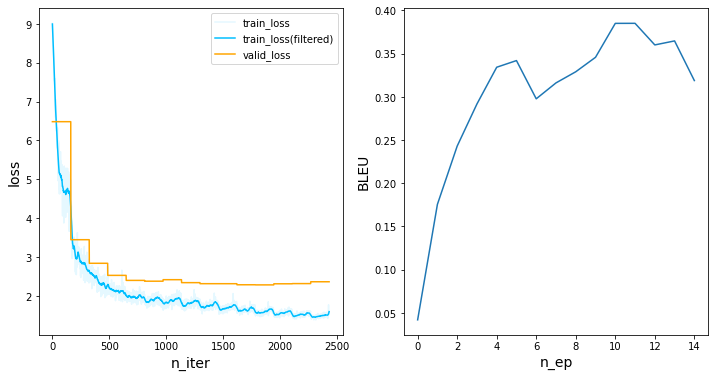

In [25]:
from scipy.signal import savgol_filter
plt.figure(figsize= (12,6))
plt.subplot(1,2,1)
plt.plot(train_loss_arr,"deepskyblue", alpha = 0.1)
plt.plot(savgol_filter(train_loss_arr, 61, 5),"deepskyblue")
plt.plot(np.array(valid_loss_arr).repeat(162),"orange")
plt.legend(("train_loss","train_loss(filtered)","valid_loss"))
plt.xlabel("n_iter",fontsize = 14)
plt.ylabel("loss",fontsize = 14)
plt.subplot(1,2,2)
plt.ylabel("BLEU", fontsize = 14)
plt.xlabel("n_ep", fontsize = 14)
plt.plot(test_bleu_arr)
plt.savefig("Figure/loss_score.png")

In [30]:
def sample_inference(model, iteration):
    iteration.batch_size = 1
    sample_idx = np.random.randint(0,high = len(iteration.data()),size= 1)[0]
    data_iter = iter(iteration)
    batch = None
    for i in range(sample_idx):
        batch = next(data_iter)
    src, trg = batch.src, batch.trg
    src_token, trg_token = [SRC.vocab.itos[idx] for idx in src[0]], [TRG.vocab.itos[idx] for idx in trg[0]]
    model.eval()
    pred = None
    with torch.no_grad():
        output = model(src, trg)[0]
        pred_as_train = output.argmax(dim = -1).squeeze()[:-1] #p
        pred_as_train = [TRG.vocab.itos[idx] for idx in pred_as_train]
        pred = trg[:,0].view(1,1)
        for idx in range(30):
            output = model(src, pred)[0]
            output = output.argmax(dim= -1)#bxp
            if output[0,-1] == TRG.vocab.stoi['<eos>']:
                break
            pred = torch.cat([pred, output[:,-1:]], axis = -1)
    pred = [TRG.vocab.itos[idx] for idx in pred[0]]
    print(f"src: {' '.join(src_token)}\ntrg: {' '.join(trg_token)}\npred_as_train: {' '.join(pred_as_train)}\npred:{' '.join(pred)}")
    iteration.batch_size = config.batch_size
sample_inference(model, test_iter)

src: <sos> ein mann in traditionellem gewand steht neben seinem esel , der anscheinend auch bekleidet ist . <eos>
trg: <sos> man clothed in a traditional dress like attire , while standing next to his mule who also seems to be clothed as well . <eos>
pred_as_train: a in in traditional robe robe stands he is standing standing next to his donkey . is . to him off . she . <eos>
pred:<sos> a man in indian garb stands by the donkey attached to him .


src: ['<sos>', 'geparkte', 'autos', 'mit', 'einem', 'schulbus', 'dahinter', '.', '<eos>']
trg: ['<sos>', 'parked', 'cars', 'with', 'a', 'school', 'bus', 'behind', 'them', '.', '<eos>']
pred_as_train: ['cars', 'cars', 'with', 'a', 'school', 'bus', 'with', 'them', '.', '<eos>']


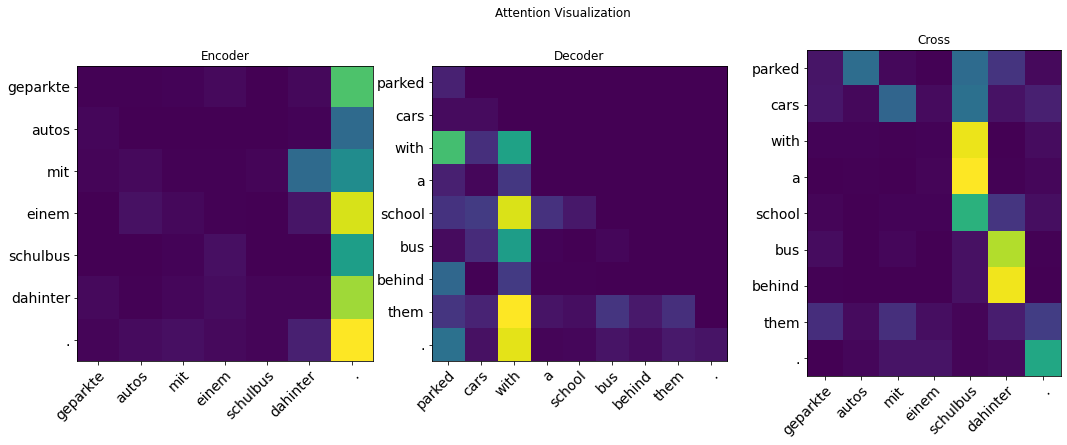

In [35]:
def attention_visualization(model, iteration, enc_self_head, dec_self_head, cross_head):
    iteration.batch_size = 1
    sample_idx = np.random.randint(0,high = len(iteration.data()),size= 1)[0]
    data_iter = iter(iteration)
    batch = None
    for i in range(sample_idx):
        batch = next(data_iter)
    src, trg = batch.src, batch.trg
    # print(src, trg)
    src_token, trg_token = [SRC.vocab.itos[idx] for idx in src[0]], [TRG.vocab.itos[idx] for idx in trg[0]]
    model.eval()
    pred = None
    with torch.no_grad():
        output, enc_self_attn, dec_self_attn, cross_attn = model(src, trg)
        pred = output.argmax(dim = -1).squeeze()[:-1] #p
        pred = [TRG.vocab.itos[idx] for idx in pred]
        fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (18,6))
        fig.suptitle("Attention Visualization")
        im = ax1.imshow(enc_self_attn[-1][0, enc_self_head][1:-1,1:-1].cpu().detach().numpy())
        ax1.set_xticks(range(len(src_token[1:-1])))
        ax1.set_xticklabels(src_token[1:-1], fontsize = 14)
        ax1.set_yticks(range(len(src_token[1:-1])))
        ax1.set_yticklabels(src_token[1:-1], fontsize = 14)
        plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
        ax1.set_title("Encoder")
        
        im = ax2.imshow(dec_self_attn[-1][0, dec_self_head][1:-1,1:-1].cpu().detach().numpy())
        ax2.set_xticks(range(len(trg_token[1:-1])))
        ax2.set_xticklabels(trg_token[1:-1], fontsize = 14)
        ax2.set_yticks(range(len(trg_token[1:-1])))
        ax2.set_yticklabels(trg_token[1:-1], fontsize = 14)
        ax2.set_title("Decoder")
        plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

        im = ax3.imshow(cross_attn[-1][0, cross_head][1:-1,1:-1].cpu().detach().numpy())
        ax3.set_yticks(range(len(trg_token[1:-1])))
        ax3.set_yticklabels(trg_token[1:-1], fontsize = 14)
        ax3.set_xticks(range(len(src_token[1:-1])))
        ax3.set_xticklabels(src_token[1:-1], fontsize = 14)
        ax3.set_title("Cross")
        plt.setp(ax3.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
        
    # pred = [TRG.vocab.itos[idx] for idx in pred[0]]
    print(f"src: {src_token}\ntrg: {trg_token}\npred_as_train: {pred}")#\npred:{pred}")
    iteration.batch_size = config.batch_size
# sample_inference(model, test_iter)
attention_visualization(model, test_iter, 0,0,0)
plt.savefig("Figure/attention_visualiation.png")